# Preparação dos Dados

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
caminho_arquivo = '/content/drive/MyDrive/TCC - UFMS/TCC - UFMS - final/Journal/Modelo de Categorização/result.csv'
df = pd.read_csv(caminho_arquivo)

In [5]:
df.head()

,Unnamed: 0,Frase,Categoria
0,0,ela é muito sensual,Aparência
1,1,menina bela,Aparência
2,2,você é diferente,Caráter
3,3,ela é linda,Aparência
4,4,ela é guerreira,Caráter


In [6]:
df = df[df['Categoria'].notna()]

In [7]:
categoria_counts = df['Categoria'].value_counts()
print(categoria_counts)

Categoria
Caráter         5569
Aparência       5261
Emoção          3704
Papel social    2817
Neutro          2728
Sexual           200
Name: count, dtype: int64


In [8]:
X = df['Frase'].values  # Frases
y = df['Categoria'].values  # Rótulos

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Categoria'])

In [11]:
classes_mapeadas = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(classes_mapeadas)

{'Aparência': 0, 'Caráter': 1, 'Emoção': 2, 'Neutro': 3, 'Papel social': 4, 'Sexual': 5}


In [12]:
from imblearn.over_sampling import RandomOverSampler

In [13]:
def balance_classes(X, y):
    ros = RandomOverSampler(random_state=42)
    X, y = ros.fit_resample(X.reshape(-1, 1), y)
    return X.flatten(), y

In [14]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [15]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Treinamento

In [16]:
# treinamento
def train_model(model, data_loader, optimizer):
    model = model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)

# Avaliação

In [17]:
# avaliação
def evaluate_model(model, data_loader):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == labels)
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1


In [18]:
# tokenizer e o modelo BERTimbau
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validação Cruzada Estratificada


In [19]:
# Definir o número de folds para validação cruzada
n_splits = 10 #10 é o mais comum, mas pode aumentar o número de folds desde que contenha no minimo 30 exemplos em cada fold, ex: 100 exemplos anotados, deve ter no maximo 3 folds / Deve-se saber tbm, que quanto maior o número de folds, maior o custo computacional
skf = StratifiedKFold(n_splits=n_splits)

In [20]:
# Otimizador
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
all_fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Treinamento e Avaliação de Modelo com Validação Cruzada Estratificada e Balanceamento de Classes

In [22]:
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}/{n_splits}")

    # Dividir os dados em treino e teste
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Balancear as classes no conjunto de treino
    X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)

    # Criar datasets e dataloaders
    train_dataset = TextDataset(X_train_balanced, y_train_balanced, tokenizer)
    test_dataset = TextDataset(X_test, y_test, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # mini-batch de tamanho 16 e shuffle para pegar amostras aleatórias
    test_loader = DataLoader(test_dataset, batch_size=16) # mini-batch de tamanho 16

    # Treinar o modelo no fold atual
    train_loss = train_model(model, train_loader, optimizer)
    print(f"Loss de treino no Fold {fold+1}: {train_loss}") #quanto menor a loss em cada fold significa que o modelo está aprendendo

    # Avaliar o modelo no fold atual
    accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
    #print(f"Acurácia no Fold {fold+1}: {accuracy}")
    #print(f"Precisão no Fold {fold+1}: {precision}")
    #print(f"Recall no Fold {fold+1}: {recall}")
    #print(f"F1-score no Fold {fold+1}: {f1}")

    # Armazenar métricas para cada fold
    all_fold_metrics['accuracy'].append(accuracy)
    all_fold_metrics['precision'].append(precision)
    all_fold_metrics['recall'].append(recall)
    all_fold_metrics['f1'].append(f1)

# Cálculo das métricas finais (médias)
final_accuracy = np.mean(all_fold_metrics['accuracy'])
final_precision = np.mean(all_fold_metrics['precision'])
final_recall = np.mean(all_fold_metrics['recall'])
final_f1 = np.mean(all_fold_metrics['f1'])

print(f"\nDesempenho Final:")
print(f"Accuracy Média: {final_accuracy}")
print(f"Precision Média: {final_precision}")
print(f"Recall Médio: {final_recall}")
print(f"F1-score Médio: {final_f1}")

Fold 1/10
Loss de treino no Fold 1: 0.4400686438710607
Fold 2/10
Loss de treino no Fold 2: 0.12638673951571927
Fold 3/10
Loss de treino no Fold 3: 0.0668958566811659
Fold 4/10
Loss de treino no Fold 4: 0.042480738162858155
Fold 5/10
Loss de treino no Fold 5: 0.03190246368492111
Fold 6/10
Loss de treino no Fold 6: 0.02135756178711048
Fold 7/10
Loss de treino no Fold 7: 0.01674536968552894
Fold 8/10
Loss de treino no Fold 8: 0.015272832625270624
Fold 9/10
Loss de treino no Fold 9: 0.014649974716953597
Fold 10/10
Loss de treino no Fold 10: 0.010348253927990532

Desempenho Final:
Accuracy Média: 0.9835304990128335
Precision Média: 0.9836906919035492
Recall Médio: 0.9835304990128335
F1-score Médio: 0.983518259430844


Baixar modelo para uso posterior

In [23]:
!mkdir model
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")

!zip -r /content/model.zip /content/model

from google.colab import files
files.download("/content/model.zip")

  adding: content/model/ (stored 0%)
  adding: content/model/special_tokens_map.json (deflated 42%)
  adding: content/model/model.safetensors (deflated 7%)
  adding: content/model/tokenizer_config.json (deflated 75%)
  adding: content/model/vocab.txt (deflated 52%)
  adding: content/model/config.json (deflated 56%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Utilizando o Modelo para o Feminino

In [24]:
caminho_arquivo1 = '/content/drive/MyDrive/TCC - UFMS/TCC - UFMS - final/Modelo de Classificação de Sentimentos/Resultados/df1_com_previsoes.csv'
df1 = pd.read_csv(caminho_arquivo1)

In [25]:
df1.head()

,Padrão,Frase,Nome da Música,Artista,Gênero Musical,Letra da Música,Sentimento
0,sujeito_aux_adv_adj,ela é muito sensual,Carolina,Seu Jorge,MPB,Carolina é uma menina bem difícil de esquecer ...,Negativo
1,sujeito_adj,menina bela,Carolina,Seu Jorge,MPB,Carolina é uma menina bem difícil de esquecer ...,Positivo
2,pronoun+aux+adj,você é diferente,Tarde Vazia (feat. Samuel Rosa) - Versão Acústica,Ira!,Rock,"Pela janela vejo fumaça, vejo pessoas Na rua o...",Neutro
3,sujeito_aux_adj,ela é linda,Rodo cotidiano,O Rappa,Rock,Ô ô ô ô ô my brother Ô ô ô ô ô my brother Ô ô ...,Positivo
4,sujeito_aux_adj,ela é guerreira,Ela Vai Voltar (Todos Os Defeitos De Uma Mulhe...,Charlie Brown Jr.,Rock,"Minha mente, nem sempre tão lúcida É fértil e ...",Positivo


In [26]:
df1.shape

(15223, 7)

In [27]:
sentencas = df1['Frase'].tolist()

In [28]:
batch_size = 16
predicoes_finais = []
model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [29]:
# mini batch
for i in range(0, len(sentencas), batch_size):
    sentencas_lote = sentencas[i:i+batch_size]

    tokens = tokenizer(
        sentencas_lote,
        padding=True,
        truncation=True,
        max_length=128,  # Mesmo max_length usado no treino
        return_tensors="pt"
    )

    tokens = {key: val.to(device) for key, val in tokens.items()}

    with torch.no_grad():
        outputs = model(**tokens)

    # Obter as previsões (softmax -> argmax para pegar a classe mais provável)
    pred_classes = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Mover para a CPU pq tava dando estouro de GPU

    predicoes_finais.extend(pred_classes)

{'Aparência': 0, 'Caráter': 1, 'Emoção': 2, 'Papel Social': 3, 'Sexual': 4}



In [30]:
df1['Categoria'] = predicoes_finais

df1['Categoria'] = df1['Categoria'].map({0: 'Aparência', 1: 'Caráter', 2: 'Emoção', 3: 'Neutro', 4: 'Papel Social', 5: 'Sexual'}) #{'Aparência': 0, 'Caráter': 1, 'Emoção': 2, 'Neutro': 3, 'Papel social': 4, 'Sexual': 5}



In [31]:
from google.colab import files

df1.to_csv('df1_com_previsoes.csv', index=False)
files.download('df1_com_previsoes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
sentimento_counts_df1 = df1['Categoria'].value_counts()
print(sentimento_counts_df1)

Categoria
Aparência       5135
Caráter         3079
Emoção          2805
Neutro          2079
Papel Social    1915
Sexual           210
Name: count, dtype: int64


# Utilizando o Modelo para o Masculino

In [33]:
caminho_arquivo2 = '/content/drive/MyDrive/TCC - UFMS/TCC - UFMS - final/Modelo de Classificação de Sentimentos/Resultados/df2_com_previsoes.csv'
df2 = pd.read_csv(caminho_arquivo2)

In [34]:
df2.head()

,Padrão,Frase,Nome da Música,Artista,Gênero Musical,Letra da Música,Sentimento
0,nome_NOUN,caro pai,Lugar Ao Sol,Charlie Brown Jr.,Rock,"Que bom viver, como é bom sonhar E o que ficou...",Neutro
1,pronoun_aposto_adjetivo_noun_det,"você, o mar","Eu, Você, O Mar e Ela",Luan Santana,Sertanejo,Ser romântico às vezes ajuda Mas se fecho os o...,Neutro
2,nome_aux_NOUN,cês são padre,Balão,Orochi,Trap,"Dallass, yo Bom dia pra você e pra todos que e...",Neutro
3,nome_NOUN,meto marcha,Deus é por nós,MC Marks,Funk,"(Ai, ai, ai, ai, ai) (Ai, ai, ai, ai, ai) (É o...",Neutro
4,sujeito_NOUN,namorado ficar,Meu Pedaço de Pecado,João Gomes,Forró,Meu pedaço de pecado De corpo colado Vem dança...,Neutro


In [35]:
df2.shape

(15081, 7)

In [36]:
sentencasMasc = df2['Frase'].tolist()

In [37]:
batch_size = 16

predicoes_finais2 = []

model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [38]:
# mini batch
for i in range(0, len(sentencasMasc), batch_size):
    sentencas2_lote = sentencasMasc[i:i+batch_size]

    tokens = tokenizer(
        sentencas2_lote,
        padding=True,
        truncation=True,
        max_length=128,  # Mesmo max_length usado no treino
        return_tensors="pt"
    )

    tokens = {key: val.to(device) for key, val in tokens.items()}

    with torch.no_grad():
        outputs2 = model(**tokens)

    # Obter as previsões (softmax -> argmax para pegar a classe mais provável)
    pred_classes2 = torch.argmax(outputs2.logits, dim=1).cpu().numpy()  # Mover para a CPU pq tava dando estouro de GPU

    predicoes_finais2.extend(pred_classes2)

In [39]:
df2['Categoria'] = predicoes_finais2

df2['Categoria'] = df2['Categoria'].map({0: 'Aparência', 1: 'Caráter', 2: 'Emoção', 3: 'Neutro', 4: 'Papel Social', 5: 'Sexual'})

In [40]:
from google.colab import files

df2.to_csv('df2_com_previsoes.csv', index=False)
files.download('df2_com_previsoes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
sentimento_counts_df2 = df2['Sentimento'].value_counts()
print(sentimento_counts_df2)

Sentimento
Neutro      5878
Positivo    5370
Negativo    3833
Name: count, dtype: int64


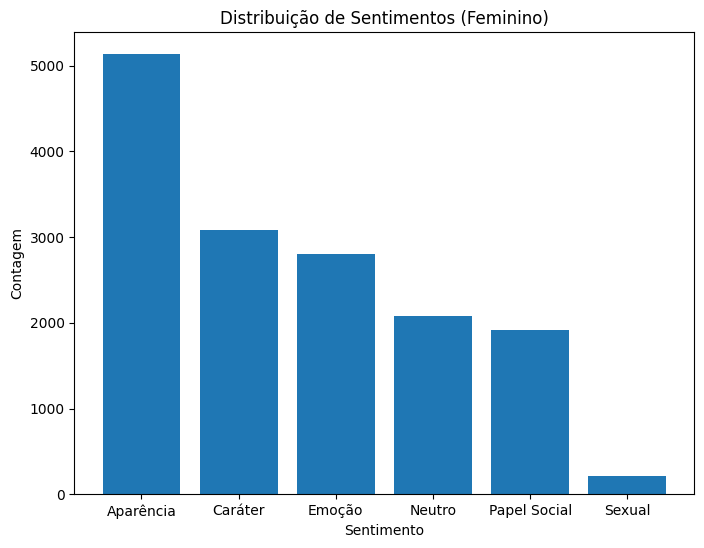

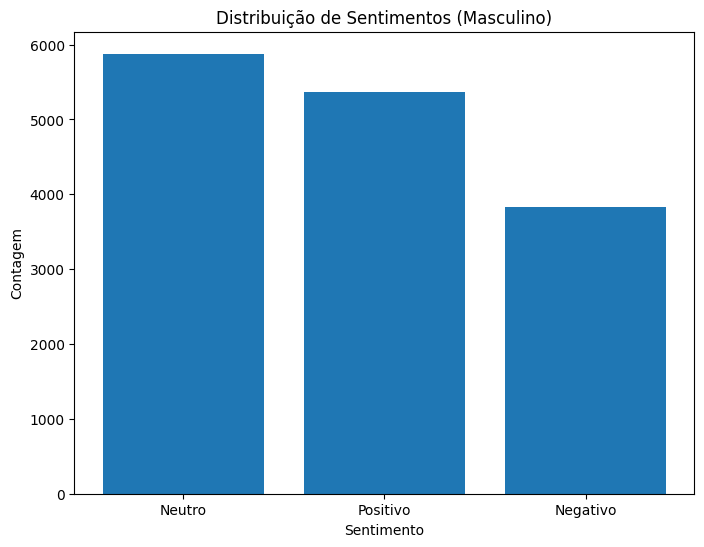

In [42]:
import matplotlib.pyplot as plt

# Gráfico para df1
plt.figure(figsize=(8, 6))
plt.bar(sentimento_counts_df1.index, sentimento_counts_df1.values)
plt.title('Distribuição de Sentimentos (Feminino)')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.show()

# Gráfico para df2
plt.figure(figsize=(8, 6))
plt.bar(sentimento_counts_df2.index, sentimento_counts_df2.values)
plt.title('Distribuição de Sentimentos (Masculino)')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.show()
